In [1]:
import os, sys, json
import numpy as np

ROOT_DIR = os.path.abspath("../../")
%matplotlib inline

import matplotlib.pyplot as plt

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

from samples.greppy import greppy

MODEL_TRAINED_ON_VARIANTS_NOT_COMPONENTS = False

np_depth_data = np.load(os.path.join(ROOT_DIR, 'temp/nespresso_vertuo/inference-data/np_depth_data.npy'))
np_color_data = np.load(os.path.join(ROOT_DIR, 'temp/nespresso_vertuo/inference-data/np_color_data.npy'))

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


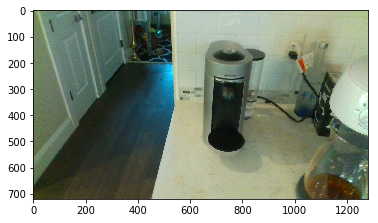

In [2]:
plt.imshow(np_color_data[...,::-1])

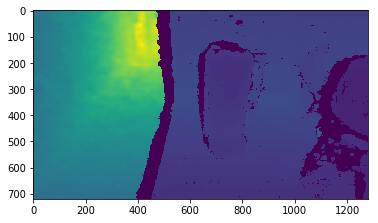

In [3]:
plt.imshow(np_depth_data)

In [4]:
DATASET_DIR = os.path.join(ROOT_DIR, "datasets/third-vertuo")
WEIGHTS_FILE = os.path.join(ROOT_DIR, "temp/nespresso_vertuo/model/mask_rcnn_nespresso_vertuo_0030.h5")
LOGS_DIR = os.path.join(ROOT_DIR, "logs/")

dataset_dict = json.load(open(os.path.join(DATASET_DIR, '_dataset.json')))
class InferenceConfig(greppy.GreppyConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    TRAINED_ON_VARIANTS_NOT_COMPONENTS = MODEL_TRAINED_ON_VARIANTS_NOT_COMPONENTS
    VARIANT_URIS = dataset_dict['variant_uris']
    COMPONENT_URIS = dataset_dict['component_uris']
    NUM_CLASSES = (1 + len(dataset_dict['variant_uris'])) if MODEL_TRAINED_ON_VARIANTS_NOT_COMPONENTS else (1 + len(dataset_dict['component_uris']))
    IS_STEREO_CAMERA = dataset_dict['camera']['is_stereo_camera']
    # Skip detections with < 80% confidence
    DETECTION_MIN_CONFIDENCE = 0.8
config = InferenceConfig()
model = modellib.MaskRCNN(mode="inference", config=config, model_dir=LOGS_DIR)
model.load_weights(WEIGHTS_FILE, by_name=True)

Processing 1 images
image                    shape: (720, 1280, 4)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 4)    min: -123.70000  max:  146.10000  float64
image_metas              shape: (1, 22)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


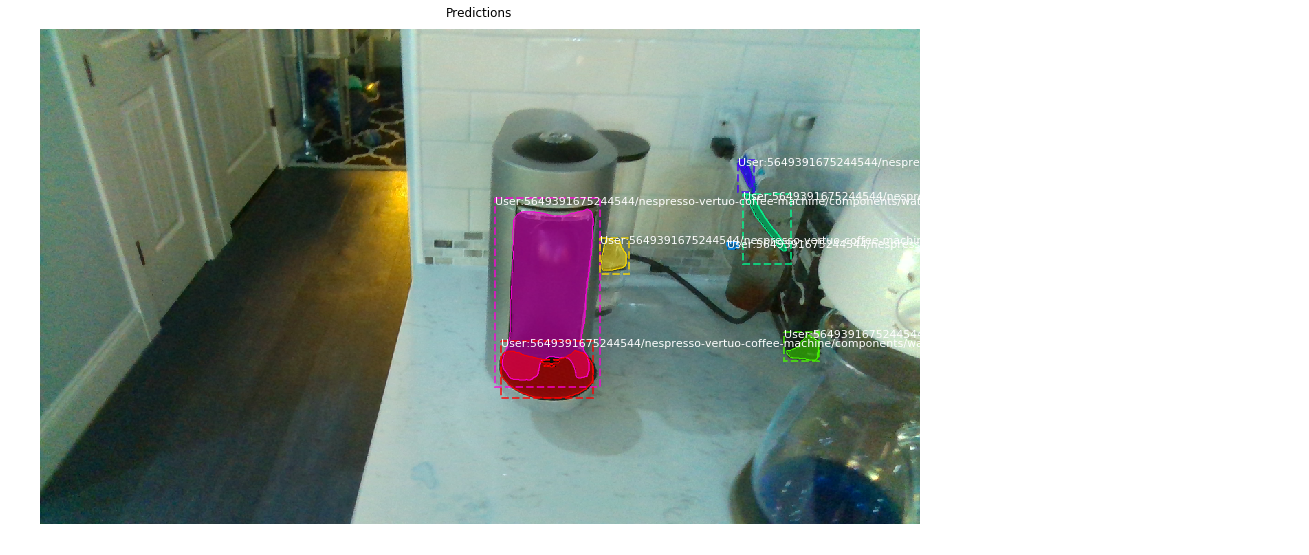

In [5]:
channels = [
    np_color_data[..., 0].astype(np.float32), # flip to BGR
    np_color_data[..., 1].astype(np.float32),
    np_color_data[..., 2].astype(np.float32),
    np_depth_data.astype(np.float32)
]
image4chan = np.stack(channels, axis=-1)
r = model.detect([image4chan], verbose=1)[0]
# Color splash
# Save image with masks
visualize.display_instances(
    np_color_data, r['rois'], r['masks'], r['class_ids'],
    config.__class__.COMPONENT_URIS, r['scores'],
    show_bbox=True, show_mask=True,
    title="Predictions")